This notebook is for the case that guiding fails during Global Alignment (1 or 2) observation 1 due to a failure of ID, ACQ, or TRK when trying for the 2nd or 3rd to engage closed-loop guiding. 

In order to follow the analysis here, you will need to first run the images you do have from NIRCam (all track and coarse images) through the Star Selection step of MAGIC, choosing an arbitrary config in order for the all PSFs file to be save out. This is necessary since it will allow us to do our analysis here of those PSFs 

In [27]:
# Import necessary packages

# Standard Library
from glob import glob
import os
from io import StringIO

# Third Party Packages
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

%matplotlib inline

This notebook currently has this set up with GA 1 and GA 2 data from MIRAGE. If you need to use this for commissioning, save a copy of this notebook and replace the indicated options in the cell below with the necessary information.

# TO DO
1. turn df creation into a function

2. add analysis sections

3. add table of contents

4. add GA2

5. come up with some extrapolation model to see how we might expect count rates to change for the next mirror move

6. set up a function that will grab all of the data if you provide a directory where only these data exist

### Set up mapping between segment names and MAGIC's labelling 

In MAGIC, we will be utilizing the all_psfs file which labels each segment with a lettering system to MAGIC. Since we will need to report our results, we will need the actual segment name. Below I set up a mapping system based on the figures shown. Note that this is only valid for an uninverted array (which is what we expect for GA). 

*Do not change these cells.*

**Guider 1**

<table><tr><td><img src="../g1_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

In [ ]:
# Do not change this cell

# MAGIC segment labels to segment naming map
segment_map_g1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}

**Guider 2**

<table><tr><td><img src="../g2_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

In [18]:
# Do not change this cell

# MAGIC segment labels to segment naming map
segment_map_g2 = {"A":"B1-7", "B":"C6-18", "C":"C1-8", "D":"B6-17",
                  "E":"A1-1", "F":"B2-9", "G":"A6-6", "H":"A2-2", 
                  "I":"C5-16", "J":"C2-10", "K":"A5-5", "L":"A3-3", 
                  "M":"B5-15", "N":"A4-4", "O":"B3-11", "P":"C4-14", 
                  "Q":"C3-12", "R":"B4-13"}

# Functions 

In [201]:
def grab_count_rate_information(all_psfs_filename, segment_map):
    """
    Given the all_psfs file for an image, retrieve the count rates for all segment PSFs and return a
    Pandas.DataFrame object (table) of the segments and their associated 3x3 count rate in order from
    segments A 1-6 -> C 1-6
    """
    
    all_psfs_table = pd.read_csv(all_psfs_filename, comment='#', names=['label', 'y', 'x', 'countrate'], sep=' ')

    segments = [segment_map[label] for label in all_psfs_table['label']]

    # Add the segment name to the table
    all_psfs_table.insert(1, 'segment', segments)
    
    seg_cr_table = all_psfs_table[['segment', 'countrate']]
    seg_cr_table = seg_cr_table.sort_values('segment', ascending=True)
    
    return seg_cr_table

In [267]:
# make a table/dictionary with instument, mode, instance, visit_group, exposure
ga_obs1_dict = {'instrument':['nircam', 'nircam', 'fgs', 'nircam', 'nircam', 'fgs', 'nircam'], 
              'mode':['track', 'coarse', 'coarse', 'track', 'coarse', 'coarse', 'track'],
              'instance':[1, 1, 1, 2, 2, 2, 3],
              'visit_group':[2, 2, 3, 5, 5, 6, 8],
              'exposure_number':[1, 2, 1, 1, 2, 1, 1]}
ga_obs1_exposures = pd.DataFrame(ga_obs1_dict)

In [268]:
ga_obs1_exposures

,instrument,mode,instance,visit_group,exposure_number
0,nircam,track,1,2,1
1,nircam,coarse,1,2,2
2,fgs,coarse,1,3,1
3,nircam,track,2,5,1
4,nircam,coarse,2,5,2
5,fgs,coarse,2,6,1
6,nircam,track,3,8,1


In [269]:
def find_exposure(ga_obs1_exposures, instrument, instance, mode):
    instrument_select = ga_obs1_exposures[ga_obs1_exposures['instrument']==instrument.lower()]
    mode_select = instrument_select[instrument_select['mode']==mode.lower()]
    instance_select = mode_select[mode_select['instance']==instance]
    
    return instance_select

In [270]:
def grab_visit_exp(ga_obs1_exposures, instrument, instance, mode):
    instance_select = find_exposure(ga_obs1_exposures, instrument, instance, mode)
    
    return int(thing['visit_group']), int(thing['exposure_number'])

In [331]:
def get_info_from_image(out_dir, root, guider, instrument, detector, mode, instance,
                        plot_image=True):

    if instrument.lower() not in ['nircam', 'fgs']:
        raise ValueError(f"What is this: {instrument}? Expect NIRCam or FGS.")


    if instrument.lower()=='fgs':
        if not detector in [1, 2]:
            raise ValueError('There are only two guiders. Please provide "1" or "2" for the guider variable')
    
    segment_map = [segment_map_g1 if guider==1 else segment_map_g2][0]
        
    if plot_image:
#         # Get specific exposure information
#         print(instrument)
#         visit_group, exp_num = grab_visit_exp(ga_obs1_exposures, instrument, instance, mode)
#         print(visit_group)
        ins = 'nrc' if instrument.lower()=='nircam' else 'g'
#         # Expected filename anatomy
#         image_filename = f'jw0{program_id}001001_0{visit_group}101_0000{exp_num}_{ins}{detector.lower()}_cal.fits'
        detector = str(detector)
        image_filename = glob(os.path.join(out_dir, 'out', root, f"*{ins}{detector.lower()}_cal.fits"))[0]
        
        # Load in the image
        image_sci = fits.getdata(image_filename)

        # Look at the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image_sci, cmap='Blues_r', vmin=0, vmax=10000)
        plt.title(f'OTE-07 (GA1) Obs1 {instrument.upper()} {mode.upper()} {instance} (SCI frame)')
        plt.show()
        
    all_psfs_filename = os.path.join(out_dir, 'out', root, f"unshifted_all_found_psfs_{root}_G{guider}.txt")
    
    seg_cr_table = grab_count_rate_information(all_psfs_filename, segment_map)
    
    return seg_cr_table

In [179]:
def count_columns(dataframe):
    """ Get the current number of columns in a dataframe
    """
    return int(dataframe.count('columns')[0])

# Global Alignment 1 

In [3]:
# Do not change these variables
program_id = 1141 
observation = 1


In [4]:
# Variables to change - these should match what was used in the MAGIC GUI
guider = 1  # Edit as necessary
nrc_detector = 'A3'
out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/'  # Directory for the practice/rehearsal/commissioning
threshold = 0.6 # Default is 0.6, change if you have changed this in the GUI


In [197]:
if guider==1:
    segment_map = segment_map_g1
elif guider==2:
    segment_map = segment_map_g2
else:
    raise ValueError('There are only two guiders. Please provide "1" or "2" for the guider variable')

## Image 1: NIRCam track #1 / SM @ 0um

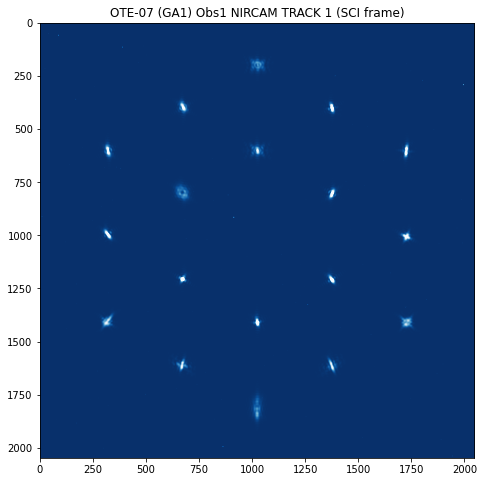

In [323]:
root = 'ote07_obs1_nrc_track1'

seg_cr_table_track_1 = get_info_from_image(out_dir, root, guider, instrument='nircam', detector=nrc_detector, 
                                           mode='track', instance=1, plot_image=True)

## Image 2: NIRCam COARSE #1 / SM @ -400um

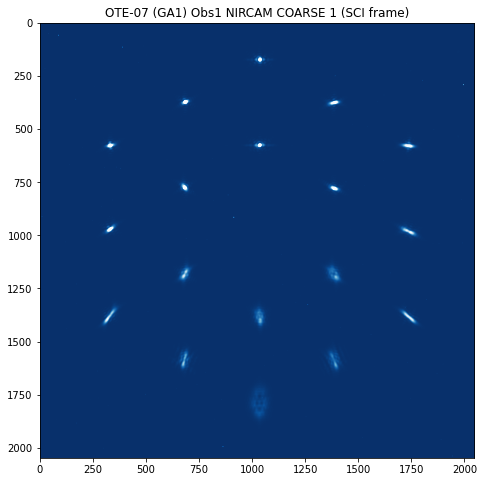

In [324]:
root = 'ote07_obs1_nrc_coarse1'

seg_cr_table_coarse_1 = get_info_from_image(out_dir, root, guider, instrument='nircam', detector=nrc_detector, 
                                           mode='coarse', instance=1, plot_image=True)

## Image 3: FGS COARSE #1 / SM @ -400um

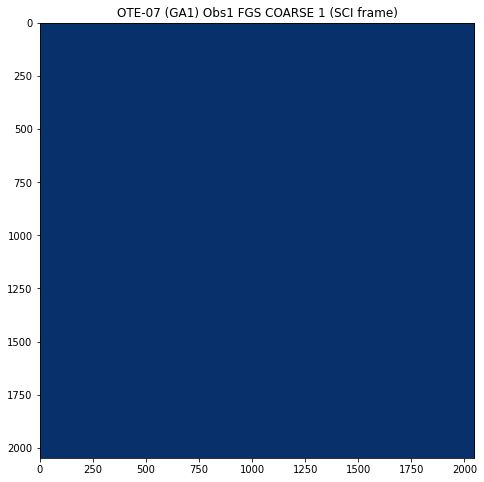

FileNotFoundError: [Errno 2] File b'/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/out/ote07_obs1_fgs_coarse1/unshifted_all_found_psfs_ote07_obs1_fgs_coarse1_G1.txt' does not exist: b'/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/out/ote07_obs1_fgs_coarse1/unshifted_all_found_psfs_ote07_obs1_fgs_coarse1_G1.txt'

In [332]:
root = 'ote07_obs1_fgs_coarse1'

seg_cr_table_fgs_coarse_1 = get_info_from_image(out_dir, root, guider, instrument='fgs', detector=guider, 
                                           mode='coarse', instance=1, plot_image=True)

## Image 4: NIRCam track #2 / SM @ -400um

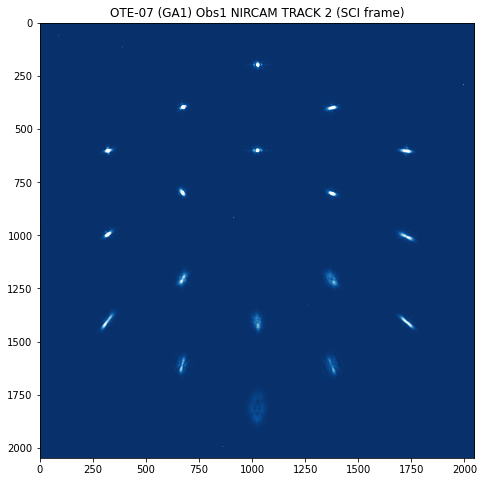

In [325]:
root = 'ote07_obs1_nrc_track2'

seg_cr_table_track_2 = get_info_from_image(out_dir, root, guider, instrument='nircam', detector=nrc_detector, 
                                           mode='track', instance=2, plot_image=True)

## Image 5: NIRCam coarse #2 / SM @ +400um

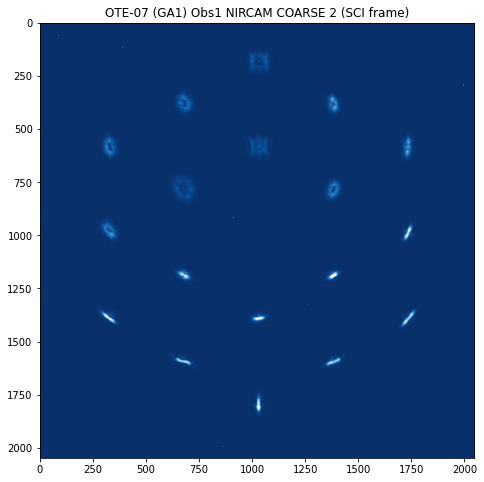

In [326]:
root = 'ote07_obs1_nrc_coarse2'

seg_cr_table_coarse_2 = get_info_from_image(out_dir, root, guider, instrument='nircam', detector=nrc_detector, 
                                           mode='coarse', instance=2, plot_image=True)

## Image 7: NIRCam track #3 / SM @ +400um

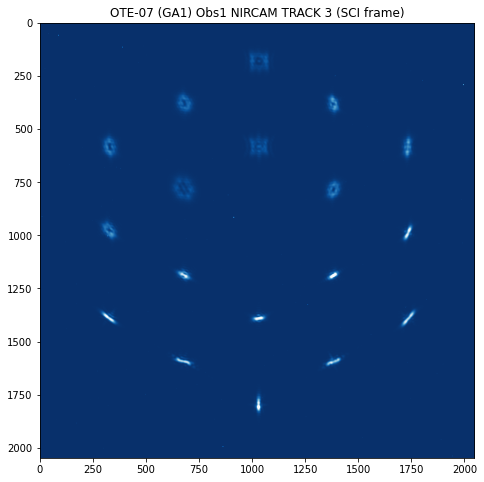

In [327]:
root_7 = 'ote07_obs1_nrc_track3' 

seg_cr_table_track_3 = get_info_from_image(out_dir, root, guider, instrument='nircam', detector=nrc_detector, 
                                           mode='track', instance=3, plot_image=True)

# Collect all the count rates across all the images

For this section you will have to edit according to where you had a failure. You can do this by deleting the lines for the images that you did not get. For the sake of this exercise, I will compare the 3x3 count rates for segment PSFs for all 5 NIRCam images

In [182]:
# Make one dataframe
all_nrc_crs = seg_cr_track_1[['segment', 'countrate']] # First track image
# Rename second column
all_nrc_crs = all_nrc_crs.rename(columns={'countrate': 'track 1 countrate'})

In [183]:
# Add additional columns - DELETE LINES IF YOU DON'T HAVE THAT DATA
all_nrc_crs.insert(count_columns(all_nrc_crs), 'coarse 1 countrate', seg_cr_coarse_1['countrate']) 
all_nrc_crs.insert(count_columns(all_nrc_crs), 'track 2 countrate', seg_cr_track_2['countrate'])
all_nrc_crs.insert(count_columns(all_nrc_crs), 'coarse 2 countrate', seg_cr_coarse_2['countrate'])
all_nrc_crs.insert(count_columns(all_nrc_crs), 'track 3 countrate', seg_cr_track_3['countrate'])

In [184]:
all_nrc_crs

,segment,track 1 countrate,coarse 1 countrate,track 2 countrate,coarse 2 countrate,track 3 countrate
8,A1-1,30690.0,81359.0,90923.0,4235.0,4452.0
5,A2-2,60242.0,73771.0,3706.0,998.0,512.0
4,A3-3,72546.0,3903.0,6414.0,41860.0,45855.0
7,A4-4,63357.0,7528.0,7611.0,30475.0,30736.0
12,A5-5,92542.0,13924.0,14271.0,19738.0,18507.0
13,A6-6,1757.0,9227.0,96164.0,2381.0,2468.0
9,B1-7,9671.0,81757.0,82092.0,2341.0,2513.0
2,B2-9,30707.0,39338.0,41034.0,8678.0,9095.0
0,B3-11,12442.0,21581.0,24628.0,16543.0,20134.0
10,B4-13,10380.0,2209.0,2274.0,21438.0,25327.0


### Now what??

### A. 
See if the problem is difference in the count rate we gave and that of the actual data - will need to include input data (w/ FGS image)

1. compare difference between coarse and track countrates - % difference

2. include FGS data in this

### B. 
Look at % change between track and next coarse image (we will have the % error that we can expect from the above analysis)

### C.
Given the data we do have, determine an extrapolation model for what PSFs/what count rate thresholds we need (I need to actually do that work)

## Failure after first mirror move

## Failure after second mirror move

# Data Analysis - only for if you have all data

## Compare TRACK data (if you have it)

In [186]:
track_nrc_crs = all_nrc_crs[['segment', 'track 1 countrate', 'track 2 countrate', 'track 3 countrate']]
track_nrc_crs

,segment,track 1 countrate,track 2 countrate,track 3 countrate
8,A1-1,30690.0,90923.0,4452.0
5,A2-2,60242.0,3706.0,512.0
4,A3-3,72546.0,6414.0,45855.0
7,A4-4,63357.0,7611.0,30736.0
12,A5-5,92542.0,14271.0,18507.0
13,A6-6,1757.0,96164.0,2468.0
9,B1-7,9671.0,82092.0,2513.0
2,B2-9,30707.0,41034.0,9095.0
0,B3-11,12442.0,24628.0,20134.0
10,B4-13,10380.0,2274.0,25327.0


## Compare COARSE data (if you have it)

In [188]:
coarse_nrc_crs = all_nrc_crs[['segment', 'coarse 1 countrate', 'coarse 2 countrate']]
coarse_nrc_crs

,segment,coarse 1 countrate,coarse 2 countrate
8,A1-1,81359.0,4235.0
5,A2-2,73771.0,998.0
4,A3-3,3903.0,41860.0
7,A4-4,7528.0,30475.0
12,A5-5,13924.0,19738.0
13,A6-6,9227.0,2381.0
9,B1-7,81757.0,2341.0
2,B2-9,39338.0,8678.0
0,B3-11,21581.0,16543.0
10,B4-13,2209.0,21438.0


# Bright object list
(new work July 2021)

RUN THE ABOVE DATA AGAIN WITH NEW MAGIC

TO DO:
1. Grab bright object list for current state
2. plot bright object list information with guiding selections file on input image (doesn't matter which image, just determine the matching between the two lists)


In [5]:
# Use a BS list to start\
bright_object_list = glob(os.path.join(out_dir, 'out', 'ote07_obs1_fgs_coarse1', 'guiding_config_1', 'dhas_shifted',
                                       '*.bobj'))[0]
bright_object_list

'/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/out/ote07_obs1_fgs_coarse1/guiding_config_1/dhas_shifted/idSim_cfg_default_20210713_164854.bobj'

In [16]:
bright_object_df = pd.read_csv(bright_object_list)

bright_object_df

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,27,1,1508,1118,1194,7792
1,1,30,1,1668,1208,1016,7289
2,2,21,2,1183,1116,997,7404
3,3,27,2,1502,1301,1180,6853
4,4,24,1,1343,1209,1109,6316
5,5,30,2,1674,1028,883,6039
6,6,21,1,1177,1302,839,5667
7,7,24,1,1340,1392,750,4678
8,8,18,2,1018,1208,595,4116
9,9,30,2,1682,836,388,2440


In [29]:
bright_object_df['FPA Row (pixels)'].values

array([1508, 1668, 1183, 1502, 1343, 1674, 1177, 1340, 1018, 1682, 1029,
       1025, 1028])

In [24]:
# Plot the bright object list over a pseudo-fgs image with the magic values so we can join the two datasets
root = 'ote07_obs1_nrc_track1'
instrument = 'nircam'
mode = 'track'
instance = 1
ins = 'nrc' 
#         # Expected filename anatomy
#         image_filename = f'jw0{program_id}001001_0{visit_group}101_0000{exp_num}_{ins}{detector.lower()}_cal.fits'
detector = str(nrc_detector)
image_filename = os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                              'unshifted_ote07_obs1_nrc_track1_G1.fits') 
                      #f"*{ins}{detector.lower()}_cal.fits"))[0]

# Load in the image
image_sci = fits.getdata(image_filename)

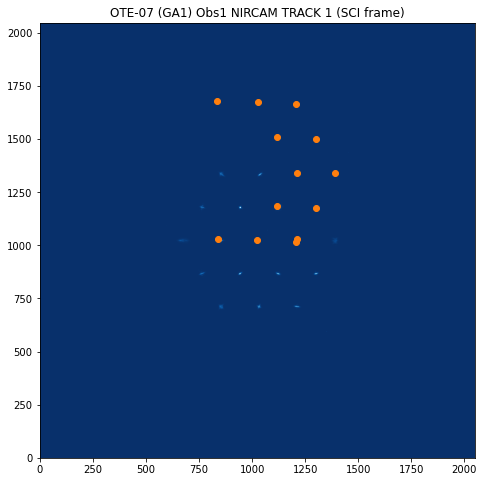

In [33]:
# Look at the image
plt.figure(figsize=(10, 8))
plt.imshow(image_sci, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')

# bright object list
plt.scatter(bright_object_df['FPA Column (pixels)'].values, 
            bright_object_df['FPA Row (pixels)'].values, color='C1')


plt.title(f'OTE-07 (GA1) Obs1 {instrument.upper()} {mode.upper()} {instance} (SCI frame)')
plt.show()

# Taking a step back 

- input image from LOS-02, use this to make our override files (star file in the DHAS world)
- failed run
- get down the data
    - EX1: failed after first mirror move
        - FGS ID, acq, trk before mirror move
        - NIRCam image in Track before mirror move
        - NIRCam in coarse
        - FGS im coarse
        - FGS track-attempt products where it failed (should at least have ID)
    - EX2: failed after second mirror move
        - all products above, plus:
        - completed 2nd track attempt files
        - NIRCam image in track 
        - NIRCam in coarse
        - FGS in coarse
        - FGS track-attempt products where it failed
        
If we fail after the second mirror move (EX2), we can discuss it as a team, but since we have NIRCam coarse images, we have all the information we need (in theory) to carry on. 

EX1 is the most likely case so we will look at that one here. 

In MAGIC to make test products:

- use LOS-02 obs 2 image to make "override file" (make .star file that will act as the override file in DHAS)
- use FGS point source seed image from MIRAGE to make your pseudo ID strips 
- look at the NIRCam track image, NIRCam coarse, and FGS coarse
- (you would also probably look at data from first track attempt, but we don't have that, we could make it from the NIRCam track image, but it's probably not necessary for analysis, we might see some variations in the counts...)

### Parameters to change 

In [54]:
threshold = .9
guider = 1 
nrc_detector = 'A3'

out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/' 
# We expect MAGIC directory structures for each of the following
root_psuedo_fgs = 'for_ote07_obs1'
root_nrc_track_1 = 'ote07_obs1_nrc_track1'
root_nrc_coarse_1 = 'ote07_obs1_nrc_coarse1'
root_fgs_coarse_1 = 'ote07_obs1_fgs_coarse1'
# This will not be in the above directory
bright_object_list = glob(os.path.join(out_dir, 'out', root_fgs_coarse_1, 'guiding_config_1', 
                                        'dhas_shifted', '*.bobj'))[0]

### Parameters to NOT change 

In [49]:
# Do not change these variables
program_id = 1141 
observation = 1

In [ ]:
if guider==1:
    segment_map = segment_map_g1
elif guider==2:
    segment_map = segment_map_g2
else:
    raise ValueError('There are only two guiders. Please provide "1" or "2" for the guider variable')

## Input image and commanded segments with count rates

In [31]:
# Guiding selections file
# The first row is the guide star, subsequent rows are reference stars. Order of ref stars doesn't matter.
commanded = pd.read_csv(os.path.join(out_dir, 'out', root, 'guiding_config_1',
                        f'shifted_guiding_selections_{root}_G{guider}_config1.txt'),
                        skiprows=1, delimiter=' ', names=['y', 'x', 'countrate'])

commanded

,y,x,countrate
0,1024.5,1024.5,30726.0
1,1654.5,1216.5,26162.0
2,1667.5,853.5,15204.0


In [47]:
# Add the count rate threshold to the table
thresholds = threshold * commanded['countrate'].values

commanded['thresholds'] = thresholds

commanded

,y,x,countrate,thresholds
0,1024.5,1024.5,30726.0,27653.4
1,1654.5,1216.5,26162.0,23545.8
2,1667.5,853.5,15204.0,13683.6


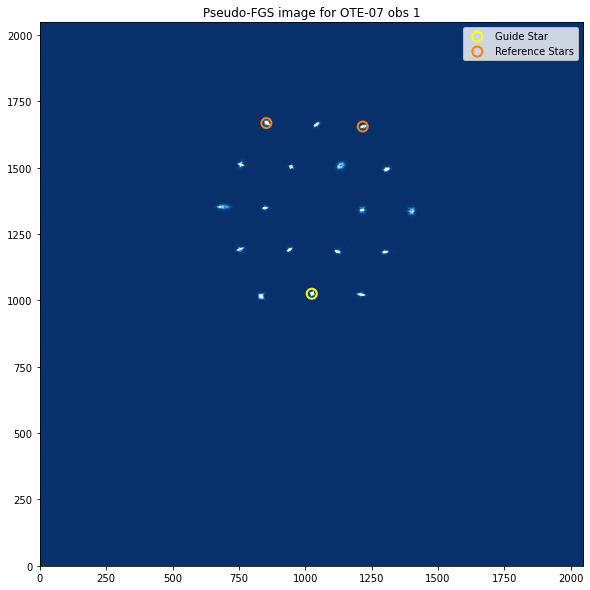

In [48]:
# Plot our Psuedo FGS image
root = root_psuedo_fgs
image_filename = os.path.join(out_dir, 'out', root, 'guiding_config_1', 'FGS_imgs', 
                                   f'shifted_{root}_G1_config1.fits')

# Load in the image
psuedo_fgs = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=100, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1:], commanded['y'].values[1:], s=100, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Stars")
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

# Look at the data products that we have

TODO: indicate config 1, 2, and 3 on these images

## NIRCam image while in Track (first attempt - no mirror move)

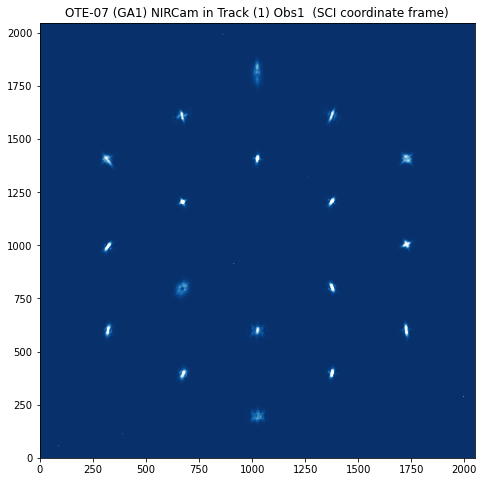

In [10]:
# Plot the bright object list over a pseudo-fgs image with the magic values so we can join the two datasets
root = root_nrc_track_1
image_filename = glob(os.path.join(out_dir, 'out', root, f'jw*_nrc{nrc_detector.lower()}_cal.fits'))[0]

# Load in the image
image_sci = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(10, 8))
plt.imshow(image_sci, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
plt.title('OTE-07 (GA1) NIRCam in Track (1) Obs1  (SCI coordinate frame)')
plt.show()

## NIRCam image while in Coarse point (after first secondary mirror move)

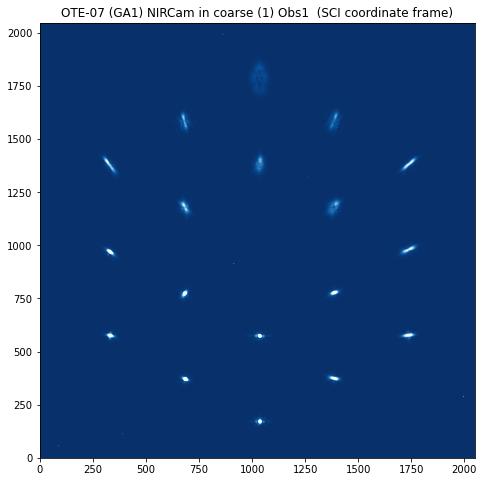

In [11]:
# Plot the bright object list over a pseudo-fgs image with the magic values so we can join the two datasets
root = root_nrc_coarse_1
image_filename = glob(os.path.join(out_dir, 'out', root, f'jw*_nrc{nrc_detector.lower()}_cal.fits'))[0]

# Load in the image
image_sci = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(10, 8))
plt.imshow(image_sci, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
plt.title('OTE-07 (GA1) NIRCam in coarse (1) Obs1  (SCI coordinate frame)')
plt.show()

## FGS image while in Coarse point (after first secondary mirror move)

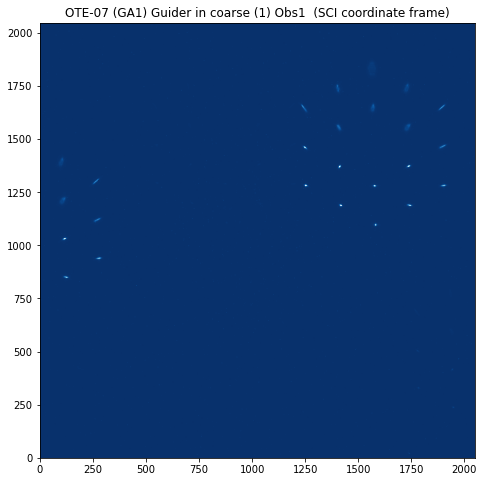

In [15]:
# Plot the bright object list over a pseudo-fgs image with the magic values so we can join the two datasets
root = root_fgs_coarse_1
image_filename = glob(os.path.join(out_dir, 'out', root, f'jw*_g{guider}_cal.fits'))[0]

# Load in the image
image_sci = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(10, 8))
plt.imshow(image_sci, cmap='Blues_r', vmin=0, vmax=50, origin='lower')
plt.title('OTE-07 (GA1) Guider in coarse (1) Obs1  (SCI coordinate frame)')
plt.show()

##  Compare
TODO: take ID strips (from sky) and run through the DAHS to get bright object list (if we don't already get it). Compare the bright object list to the command

In [55]:
# Use a BS list to start
# TODO: replace with your birght object list

bright_object_list

'/Users/kbrooks/git_repos/jwst-magic-fork/out/ga_contingency/out/ote07_obs1_fgs_coarse1/guiding_config_1/dhas_shifted/idSim_cfg_default_20210713_164854.bobj'

In [56]:
bright_object_df = pd.read_csv(bright_object_list)

bright_object_df

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,27,1,1508,1118,1194,7792
1,1,30,1,1668,1208,1016,7289
2,2,21,2,1183,1116,997,7404
3,3,27,2,1502,1301,1180,6853
4,4,24,1,1343,1209,1109,6316
5,5,30,2,1674,1028,883,6039
6,6,21,1,1177,1302,839,5667
7,7,24,1,1340,1392,750,4678
8,8,18,2,1018,1208,595,4116
9,9,30,2,1682,836,388,2440


In the above dataframe, the 'FPA Column (pixels)' column corresponds to 'x', the 'FPA Row (pixels)' column corresponds to 'y', and the 'FPA Count Sum (counts)' is our 3x3 count rate that is labelled 'countrate' in the guiding selections file.

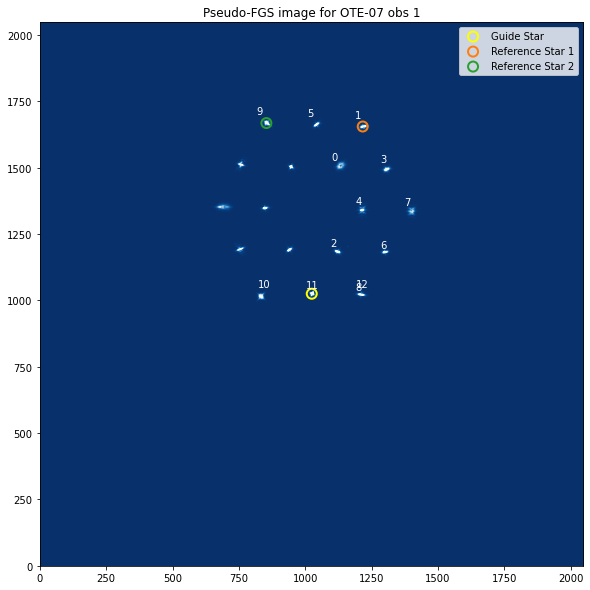

In [84]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=100, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1], commanded['y'].values[1], s=100, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Star 1")
plt.scatter(commanded['x'].values[2], commanded['y'].values[2], s=100, facecolors='none',  edgecolors='C2',
            linewidths=2.0, label="Reference Star 2")
for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

In [85]:
# Give candidate numbers of guide and reference stars
# THIS WILL CHANGE BASED ON YOUR DATA
guide_star_bobj = 11
ref_star_bobj_1 = 1 
ref_star_bobj_2 = 9

In [86]:
selected_bright_object_df = bright_object_df.loc[[guide_star_bobj, 
                                                  ref_star_bobj_1, 
                                                  ref_star_bobj_2]]

selected_bright_object_df = selected_bright_object_df[['FPA Row (pixels)', 'FPA Column (pixels)', 
                                                       ' FPA Count Sum (counts)']]

selected_bright_object_df

,FPA Row (pixels),FPA Column (pixels),FPA Count Sum (counts)
11,1025,1024,2059
1,1668,1208,7289
9,1682,836,2440


#TODO: Do I need to multiple the 3x3 countrate by the t_cds of the ID strips?

In [87]:
commanded

,y,x,countrate,thresholds
0,1024.5,1024.5,30726.0,27653.4
1,1654.5,1216.5,26162.0,23545.8
2,1667.5,853.5,15204.0,13683.6


## Analysis

[Here is where you can analysis what you have seen in the comaparison above. I will write my analysis for the above example here, you might wish to include your analysis in your notebook so you can pass that information off to the relavent teams]

### Config 1 

In [111]:
# Convert from 3x3 count rate to 3x3 counts 
t_id = 0.3406 

In [162]:
def compare_commanded_vs_measured(commanded_df, measured_df, commanded_index, measured_index):
    """
    Both data frames are expected to have the same order and number. The measured_df is expected to come from the 
    bright object list
    Index which index in the list to use: GS = 0, REF1 = 1, REF2 = 2
    """
    # Grab appropriate row in each data frame
    commanded = commanded_df.loc[[commanded_index]]
    measured = measured_df.loc[[measured_index]]
    
    # Find the floor of the *3x3 counts* that we are allowing
    commanded_counts = commanded['countrate'].values[0]*t_id
    commanded_threshold = commanded['thresholds'].values[0]*t_id
    minimum_counts = commanded_counts - commanded_threshold

    # Grab the 3x3 count sum that was measured for the same object
    measured_counts = measured[' FPA Count Sum (counts)'].values[0]
    
    # Compare
    if measured_counts < minimum_counts:
        print('The measured number of counts is below the commanded - threshold value.')
        new_threshold = (commanded_counts - measured_counts)/commanded_counts
        print(f' Recommended threshold = {new_threshold}')
    else: 
        print('The measured number of counts is equal to or greater than the commanded '
              + f'- threshold value by {np.round(measured_counts - minimum_counts)} counts.')
        new_threshold = threshold # None
        
    return new_threshold

def compare_config(commanded_df, measured_df, matching_indicies_bobj):
    
    recommended_thresholds = []
    for commanded_index, measured_index in zip(np.arange(3), matching_indicies_bobj):
        
        recommended_thresholds.append(compare_commanded_vs_measured(commanded_df, measured_df, 
                                                                    commanded_index, measured_index))
        
    if all(thresh == threshold for thresh in recommended_thresholds):
        print(f"No new threshold needed. Config should have passed ID with threshold of {threshold}")
    else:
        recommended_new_threshold = max(recommended_thresholds)
        print(f"Recommended new threshold = {recommended_new_threshold}")

#### Guide star 

In [161]:
compare_config(commanded, selected_bright_object_df, [guide_star_bobj, ref_star_bobj_1, ref_star_bobj_2])

The measured number of counts is equal to or greater than the commanded - threshold value by 1012.0 counts.
The measured number of counts is equal to or greater than the commanded - threshold value by 6398.0 counts.
The measured number of counts is equal to or greater than the commanded - threshold value by 1922.0 counts.
No new thershold needed. Config should have passed ID with threshold of 0.9


# TODO: How to test new products? Use the new command with actual ID strips in DHAS